In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

* Probability and Bayes Theroem
* Infinite Hypotheses- Estimating number of locals attending PyData NYC
* Introduction to motivating problem- Finding an optimum price
* Manual evaluation of hypotheses
* Dealing with underflow: Living in Log Land
* Scaling- Speed and hypothesis evaluation
* MCMC as a scaling solution
* Programming our first MCMC algorithm
* Where does our solution break where others succeed?

# Probability and Bayes Theorem

Technically... officially...

$ P(hypothesis\ |\ data) = \frac{P(data\ |\ hypothesis)\ *\ P(hypothesis)}{P(data)}\ $

But in practice we use it like this:

$ P(hypothesis\ |\ data) \propto P(data\ |\ hypothesis) * P(hypothesis) $

Why? At the end of the day P(data) is just used to normalize to percentages.

### Wild Example of Bayesian Statistics

The entire output of a factory is produced on three machines. The three machines account for different amounts of the factory output, namely 20%, 30%, and 50%. The fraction of defective items produced is this: for the first machine, 5%; for the second machine, 3%; for the third machine, 1%. If an item is chosen at random from the total output and is found to be defective, what is the probability that it was produced by the third machine?

$$ P(M_3 | D) = \frac{P(D | M_3) * P(M_3)}{P(D)}\ $$

$$ P(M_1 | D) = \frac{ 0.05 * 0.2}{.2*0.05+0.3*0.03+0.5*0.01} = 41.7\%\ $$

$$ P(M_2 | D) = \frac{ 0.03 * 0.3}{.2*0.05+0.3*0.03+0.5*0.01} = 37.5\%\ $$

$$ P(M_3 | D) = \frac{ 0.01 * 0.5}{.2*0.05+0.3*0.03+0.5*0.01} = 20.8\%\ $$

But $P(D)$ isn't necessary... what if we did this instead?

In [2]:
p_m1 = (0.05*0.2)#/(.2*0.05+0.3*0.03+0.5*0.01)
p_m2 = (0.03*0.3)
p_m3 = (0.01*0.5)

p_total = p_m1 + p_m2 + p_m3

p_m1 / p_total, p_m2 / p_total, p_m3 / p_total

(0.4166666666666667, 0.3749999999999999, 0.20833333333333331)

Actually the same thing... notice that P(D) is literally the sum of the likelihoods and we divide by it to normalize.

# Many Hypotheses
## Estimating number of locals attending PyData NYC

How many people in this room are from NYC?

Assuming there are 1,000 people at the conference, how many people do we think are locals?

First our assumptions:

In [3]:
conference_population = 1000
room_population = 50
locals_in_room_population = 15
hypothesis_count = conference_population + 1

Let's also assume that for our room it is a completely random assignment of locals and non-locals. IID.

Naively, I'm going to just include a hypothesis for every possible value even if it's logically impossible. We'll handle those cases with our likelihood function. Let's create a list of all of our hypotheses:

In [4]:
hypothesis_values = np.linspace(0,1000, num=hypothesis_count)

Let's count the number of hypotheses we have

In [5]:
hypothesis_count = len(hypothesis_values)

And let's weight each hypothesis according to our prior belief of how likely each is. For now, we'll just weight every hypothesis equally (known as an uninformative prior).

In [6]:
hypothesis_likelihoods = np.ones(hypothesis_count) / hypothesis_count

We normalize it by the hypothesis count to come up with a percentage. This is a visualization of our prior distribution:

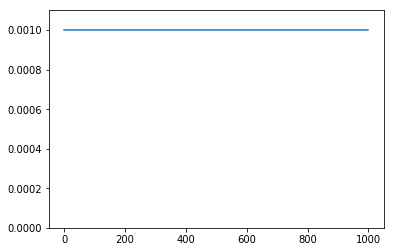

In [7]:
plt.ylim(0,0.0011)
plt.plot(hypothesis_likelihoods);

Next, we need to come up with a likelihood function we can use to evaluate each hypothesis. With some thought we can rule out certain hypotheses:

1. We can't have more locals in our room than at the conference as a whole.
2. We can't have more non-locals in our room than at the conference as a whole.
3. Of course, we can't have more locals at the conference than we have people at the conference either.

This accounts for line 2 of the below likelihood function.

Now let's say we have 15 locals out of 50 in our room at the conference with 1,000 attendees... How likely do we think it is that we have exactly 15 locals at the entire conference?

Well, for each attendee in our room we would calculate the probability of them being in the room. How so?

For each person in the room we calculate the probability of choosing each person at random out of the 1,000. So the probability you're a local and she's a local and he's a local and he's not and she's not and... Mathematically that looks like this:

In [8]:
hypothesis_for_total_locals = 15

p_local = hypothesis_for_total_locals / conference_population
p_non_local = 1. - hypothesis_for_total_locals / conference_population

(p_local ** locals_in_room_population) * (p_non_local ** (room_population - locals_in_room_population)) 

2.580102462475387e-28

What about if there were 16 locals at the conference? We'd expect that to increase our probability right?

In [9]:
hypothesis_for_total_locals = 16

p_local = hypothesis_for_total_locals / conference_population
p_non_local = 1. - hypothesis_for_total_locals / conference_population

(p_local ** locals_in_room_population) * (p_non_local ** (room_population - locals_in_room_population)) 

6.555837572329089e-28

A little bigger! Actually almost twice as likely. So we could keep going but it would take a long time. Instead we just code this into a likelihood function and write a loop.

The below code should look a lot like the above code.

In [10]:
def probability_N_chosen(locals, room_size, conference_locals, conference_size):
    if locals > conference_locals or ((room_size-locals) > (conference_size - conference_locals)):
        return 0
    return ((conference_locals / conference_size) ** locals) * ((1. - conference_locals / conference_size) ** (room_size - locals))

Next we loop through our hypotheses and evaluate each one.

In [11]:
hypothesis_likelihoods = np.array([probability_N_chosen(locals_in_room_population, 
                                                        room_population, 
                                                        hypothesis, 
                                                        conference_population) 
                                   for hypothesis in hypothesis_values])

Lastly we normalize our probabilities and plot the answer.

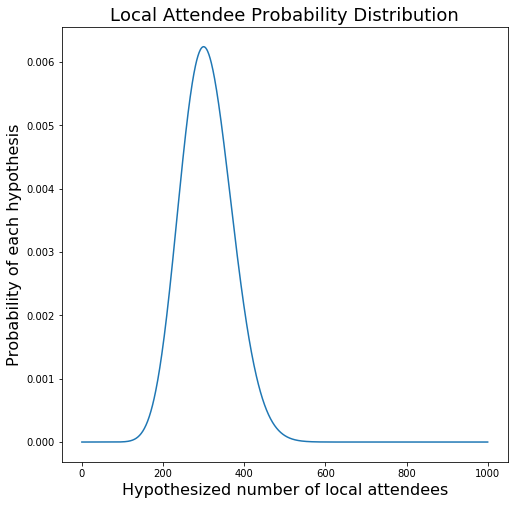

In [12]:
hypothesis_probabilities = hypothesis_likelihoods / hypothesis_likelihoods.sum()

plt.figure(figsize=(8,8))
plt.title('Local Attendee Probability Distribution', size=18)
plt.xlabel('Hypothesized number of local attendees', size=16)
plt.ylabel('Probability of each hypothesis', size=16)
plt.plot(hypothesis_probabilities);

Now we can estimate how many locals we think are here!

In [13]:
lower_bound = np.argmax(hypothesis_probabilities.cumsum() > 0.005)
upper_bound = np.argmax(hypothesis_probabilities.cumsum() > 0.995)

mode_index = np.argmax(hypothesis_probabilities)

hypothesis_values[lower_bound], hypothesis_values[mode_index], hypothesis_values[upper_bound]

(161.0, 300.0, 482.0)

So given our assumptions there's a 99% chance there's between 161 and 482 locals at PyData! Our most likely estimate would be 300 though if we had to guess but as the result below shows, there's only a 0.6% chance of it being exactly that.

In [14]:
hypothesis_probabilities[mode_index]

0.0062396899536054555

## Probability Distributions

It's worth noting that the example we just did could be solved a little easier by leveraging a specific probability distribution. In this case it's the hypergeometric distribution.

In [15]:
import scipy.stats as ss

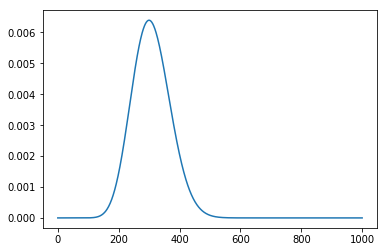

In [16]:
hypotheses = np.linspace(0,1000, num=1001)
likelihoods = ss.hypergeom.pmf(n=hypotheses, M=1000, k=15, N=50)
probabilities = likelihoods/likelihoods.sum()
plt.plot(probabilities);

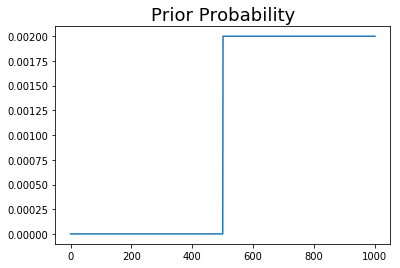

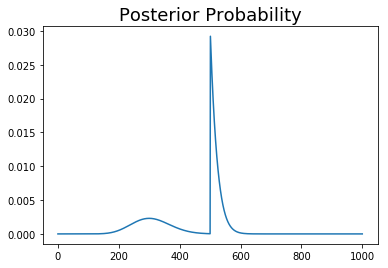

In [17]:
hypotheses = np.linspace(0,1000, num=1001)
prior_probability = np.concatenate([np.zeros(501)+0.001, np.ones(500)]) / (np.concatenate([np.zeros(501)+0.001, np.ones(500)])).sum()
likelihoods = ss.hypergeom.pmf(n=hypotheses, M=1000, k=15, N=50) * prior_probability
probabilities = likelihoods / likelihoods.sum()

plt.title('Prior Probability', size=18)
plt.plot(prior_probability);
plt.show()
plt.title('Posterior Probability', size=18)
plt.plot(probabilities);

# Probability Distributions are Your BFFs

Some common ones:

2. **Beta**- Likelihood of a given True proportion given the sampled counts. Think Conversions vs. Non-Conversions.
3. **Binomial**- Tells likelihood of a sampled proportion given a known probability of success and a fixed number of trials. Useful when we want to understand the number of successes we might observe.
4. **Poisson**- Given an average occurence rate it tells you the likelihood of an event occuring N times in the given time period. Tied to binomial and approximates Normal as the rate parameter increases.
5. **Geometric**- Tells likelihood of first success occuring on trial N.
6. **Negative Binomial**- Generalizes the geometric distribution by allowing us to find the likelihood of the Mth success occuring on trial N.
7. **Normal (aka Gaussian)**- Important because of the Central Limit Theorem and because it is used to approximate the sum of many random variables taken together.
8. **Exponential**- How much time between events?
9. **Hypergeometric**- Our problem above!
    
Want to learn more and/OR interested in the math for these?

Mathematical Statistics with Applications (7th edition)

# Approaching Infinite Hypotheses

In the previous example we had too many hypotheses to calculate by hand but definitely a finite number of them due to the fact that we were restricted to integer solutions. What happens when we care about solutions at arbitrary granularity though? 

We'll start by approaching the problem the same way and note the challenges.

## Finding an Optimum Price

A common business problem is to find the min/max of some function so that you can optimize revenue or costs. For this reason, my favorite toy example is modeling a parabola to some data.

Imagine we are tasked with optimizing our revenue for creating Super Widgets. We want to know what the optimum number of hours are for our workers to work in a day in order to maximize our revenue. We have a fixed staff size and are subject to overtime laws which is where the optimization comes into play. 

A common business problem is to find the min/max of some function so that you can optimize revenue or costs. For this reason, my favorite toy example is modeling a parabola to some data.

Imagine we are tasked with optimizing our revenue for creating Super Widgets. We want to know what the optimum number of hours are for our workers to work in a day in order to maximize our revenue. We have a fixed staff size and are subject to overtime laws which is where the optimization comes into play. 

Now! We've ran an experiment and we varied how many hours we have the average worker work for. Using this data, let's see if we can recommend an optimum.

Let's make up some hypothetical data so we can visualize the problem better.

In [18]:
import numpy as np, scipy as sp, seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

true_a = -3
true_h = 9.25
true_k = 25000
true_sigma = 10

x_data = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12]) 
observed_y = true_a * (x_data - true_h)**2 + true_k + np.random.normal(loc=0, scale=true_sigma, size=len(x_data))

Then visualize it

In [19]:
observed_y

array([ 24924.33465083,  24949.08652908,  24970.68188298,  24968.12499771,
        24983.55203499,  24990.77441232,  25000.45794035,  24965.22327695,
        24972.49164896])

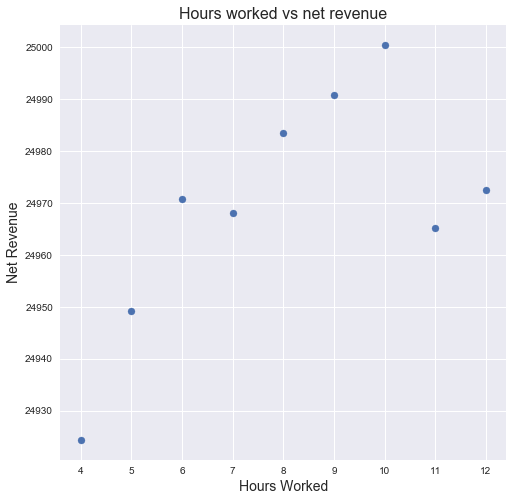

In [20]:
plt.figure(figsize=[8,8])
plt.xlabel('Hours Worked', size=14)
plt.ylabel('Net Revenue', size=14)
plt.title('Hours worked vs net revenue', size=16)
plt.scatter(x_data, observed_y);

With the naked eye we might say that 8 hour days are perfect... or maybe 11 hours? #eek Let's see what happens when we model this.

## Manual Evaluation of Hypotheses

Since we're optimizing price maybe we could assume that 
$$
y = a(x - h)^2 + k \\
$$

On top of that... we can see the data looks parabolic and we want to find the maximum point. The nice thing about modeling this with a parabola is that we can write the equation such that the exact information we want is just a parameter.

### What the parameters mean
Dependent variable

    h- hours worked

Nuisance parameters (AKA DGAF)

    k- amount of money made at our optimum
    a- width of parabola

In [21]:
import itertools

# Come up with a hypothesis for each parameter
a_hypotheses = np.array([-4, -3, -2, -1])
h_hypotheses = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
k_hypotheses = np.array([18000, 20000, 23000, 25000, 26000, 28000, 30000])
sigma_hypotheses = np.array([5, 10, 15, 20, 25])

Any parameter we aren't explicitly providing we are implicitly saying is _impossible_.

# IMPOSSIBLE

That's fine for now

How do we use what we've gathered so far to evaluate probabilities? We use all of our hypotheses above to generate *EVERY* unique hypothesis in our hypothesis space.

In [22]:
# Create list of every possible combination of them.
hypotheses = list(itertools.product(a_hypotheses, h_hypotheses, k_hypotheses, sigma_hypotheses))

Now that we have all of our hypotheses, we can continue the way we did in the previous example. We just need two things:

1. Our prior
2. Our likelihood function

We can start with a simple non-informative prior.

In [23]:
prior = np.ones(len(hypotheses))
prior

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

Next we need a way to assign a probability to each hypothesis using a likelihood function. Next we can set up a probabilistic model around the error term. Our mental model could be that if we fit our model perfectly, we'd expect the errors to be normally distributed.

The following example illustrates this but the code is not executable outside of a loop

In [24]:
for i, hypothesis in zip(range(len(hypotheses)), hypotheses):
    if hypothesis == (-3, 9, 25000, 5):
        print(i)
        break

890


In [25]:
a_hypothesis, h_hypothesis, k_hypothesis, sigma_hypothesis = hypotheses[890]
x_datum, y_datum = list(zip(x_data, observed_y))[0]

predicted_y = a_hypothesis * (x_datum - h_hypothesis)**2 + k_hypothesis
prediction_error = y_datum - predicted_y
# On average, the error should be centered around zero
# just like in a standard regression (aka normal residuals).
y_probability = ss.norm.pdf(0, loc=prediction_error, scale=sigma_hypothesis)
y_probability

0.079085143893051602

This is NOT a probability! Needs to be normalized... before it can be normalized we need to compute likelihoods for all of our hypotheses.

This we know is the best possible hypothesis because we generated the data. For each hypothesis we will find the likelihood for all of the data with that hypothesis... but watch what happens even at the most likely hypothesis:

In [26]:
y_probability ** len(observed_y)

1.2101917342165885e-10

And if we had 100x as many observations...

In [27]:
y_probability ** (100*len(observed_y))

0.0

Completely zero. In probability zero and one are certainty and no amount of data will ever change them. These are bad values we want to avoid. We'll come back to this.

In [28]:
# Start with an uninformative prior
# Every hypothesis gets an equal footing
hypothesis_likelihoods = np.array(prior)

for i, hypotheses_tuple in enumerate(hypotheses):
  a_hypothesis, h_hypothesis, k_hypothesis, sigma_hypothesis = hypotheses_tuple
  for x_datum, y_datum in zip(x_data, observed_y):
    # For the given hypothetical value of each parameter
    # let's compute a prediction and the error
    predicted_y = a_hypothesis * (x_datum - h_hypothesis)**2 + k_hypothesis
    prediction_error = y_datum - predicted_y
    
    # On average, the error should be centered around zero
    # just like in a standard regression (aka normal residuals).
    y_probability = ss.norm.pdf(0, loc=prediction_error, scale=sigma_hypothesis)
    
    # Multiply probability density
    hypothesis_likelihoods[i] *= y_probability

In [29]:
evaluated_hypotheses = list(zip(hypotheses, hypothesis_likelihoods))

In [30]:
max(evaluated_hypotheses, key=lambda x: x[-1])

((-3, 9, 25000, 10), 6.1489193282095118e-16)

So this means that the most likely estimate for the parameter values are

    a = -4
    h = 9
    k = 25000
    sigma = 5

These aren't perfect! But that's fine... the only value we care about (h) is pretty darn close. Also the last value in that tuple is supposed to represent our likelihood of this solution but there's no way that's a probability! We never normalized.

In [31]:
normalized_hypothesis_likelihoods = hypothesis_likelihoods / hypothesis_likelihoods.sum()
evaluated_normalized_hypotheses = list(zip(hypotheses, normalized_hypothesis_likelihoods))
max(evaluated_normalized_hypotheses, key=lambda x: x[-1])

((-3, 9, 25000, 10), 0.30943259524380373)

Same solution but we just have a probability amongst all of our hypotheses now.

## Dealing with Underflow: Living in Log Land

In [32]:
np.exp([-5000, -5001, -5002])

array([ 0.,  0.,  0.])

In [33]:
def log_normalize(log_p):
  shifted_p = np.exp(log_p - np.max(log_p))
  normalized_log_p = shifted_p/shifted_p.sum()
  return normalized_log_p

In [34]:
log_normalize([-5000, -5001, -5002])

array([ 0.66524096,  0.24472847,  0.09003057])

In [35]:
def fit_data(prior, hypotheses, x_data, observed_y):
    # Log
    hypothesis_likelihoods = np.log(prior)

    for i, hypotheses_tuple in enumerate(hypotheses):
      a_hypothesis, h_hypothesis, k_hypothesis, sigma_hypothesis = hypotheses_tuple
      for x_datum, y_datum in zip(x_data, observed_y):
        predicted_y = a_hypothesis * (x_datum - h_hypothesis)**2 + k_hypothesis
        prediction_error = y_datum - predicted_y

        y_probability = ss.norm.pdf(0, loc=prediction_error, scale=sigma_hypothesis)

        # Log
        hypothesis_likelihoods[i] += np.log(y_probability)
    # Log
    normalized_hypothesis_likelihoods = log_normalize(hypothesis_likelihoods)
    evaluated_normalized_hypotheses = list(zip(hypotheses, normalized_hypothesis_likelihoods))
    return evaluated_normalized_hypotheses

fixed_evaluated_normalized_hypotheses = fit_data(np.ones(len(hypotheses)), hypotheses, x_data, observed_y)
max(fixed_evaluated_normalized_hypotheses, key=lambda x: x[-1])

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


((-3, 9, 25000, 10), 0.30943259524380334)

## Solution Evaluation

Let's look at the different hypotheses weighted by their probability

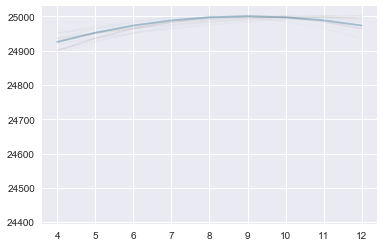

In [36]:
X = np.linspace(4, 12, num=9)

for hypothesis, probability in fixed_evaluated_normalized_hypotheses:
    if probability == 0:
        continue
    a, h, k, sigma = hypothesis
    Y = a * (X - h)**2 + k
    plt.plot(X, Y, alpha=probability);

## Performance Challenges

# MCMC 

## Shout Outs

Huge shout out to Thomas Wiecki!

@twiecki

## Motivations behind MCMC

Challenges of the above:

1. We can only evaluate discrete hypotheses. There are an infinite number of hypotheses between each integer though!
2. Evaluating more hypotheses will take exponentially longer as we add more.
3. We can solve problems even if they don't have tractable solutions like our first problem.

## Understanding MCMC Foundations

## Coding Metropolis

Let's use MCMC to solve a very simple problem: Inferring the mean of data we assume to be gaussian.

### Choose where we're at to start
For simplicity, we'll assume we start at our priors.

### Choose a proposed next value for m and b.
When choosing a next proposal for a variable we use a random distribution and some sort of limit to its width. In this case we'll use a normal distribution with a stdev of 0.5. Technically this is unbounded and serves to allow us to explore the space but is largely focused on reasonable values.


### Evaluate Where We're At vs. Proposal
We want to find $P_accept = \frac{P(\mu_{proposed} | data)}{P(\mu_{current} | data)}$. If $p_{accept} >= 1$ we accept the sample and add it to our trace.

Find the likelihood of our data for both our current location for each variable as well as the proposed location. Let's also evaluate how likely our current value and proposed values are compared to our prior. NOTE: What would happen if you chose a prior that was wildly different from the true value?

Here we need to find the $P(\mu_{current} | data) = \frac{P(data | \mu_{current}) * P(\mu_{current})}{P(data)}$. When we divide $P(\mu_{proposed} | data)$ by $P(\mu_{current} | data)$ the $P(data)$ cancels out and we can avoid computing it!



http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/

### Choose where we're at to start
For simplicity, we'll assume we start at our priors.

In [37]:
prior_m = 0
prior_m_distribution = ss.norm(loc=prior_m, scale=1.0)
m_current = prior_m
proposal_width = 0.5

### Choose a proposed next value for m.

When choosing a next proposal for a variable we use a random distribution and some sort of limit to its width. In this case we'll use a normal distribution with a stdev of 0.5. Technically this is unbounded and serves to allow us to explore the space but is largely focused on reasonable values.

In [38]:
m_proposal = ss.norm(loc=m_current, scale=proposal_width).rvs()

### Evaluate Where We're At vs. Proposal
We want to find $P_accept = \frac{P(\mu_{proposed} | data)}{P(\mu_{current} | data)}$. If $p_{accept} >= 1$ we accept the sample and add it to our trace.

Find the likelihood of our data for both our current location for each variable as well as the proposed location. Let's also evaluate how likely our current value and proposed values are compared to our prior. NOTE: What would happen if you chose a prior that was wildly different from the true value?

Here we need to find the $P(\mu_{current} | data) = \frac{P(data | \mu_{current}) * P(\mu_{current})}{P(data)}$. When we divide $P(\mu_{proposed} | data)$ by $P(\mu_{current} | data)$ the $P(data)$ cancels out and we can avoid computing it!

In [39]:
prior_distribution = ss.norm(loc=prior_m, scale=1.0)

# Make proposal
m_proposal = ss.norm(loc=m_current, scale=proposal_width).rvs()

# Find likelihood of data given the proposal for m
m_proposal_likelihood = ss.norm(loc=m_proposal, scale=1).logpdf(data).sum()

# Find likelihood of data given the current m
m_current_likelihood = ss.norm(loc=m_current, scale=1).logpdf(data).sum()

# Find likelihood of m_current given the prior
m_current_prior_likelihood = prior_distribution.logpdf(m_current)
m_proposal_prior_likelihood = prior_distribution.logpdf(m_proposal)

# Compute proportional probability
m_current_probability = m_current_likelihood + m_current_prior_likelihood
m_proposal_probability = m_proposal_likelihood + m_proposal_prior_likelihood

m_accept_probability = m_proposal_probability - m_current_probability

NameError: name 'data' is not defined

## All Together Now

In [40]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as ss

def sampler(data, samples=1000, mu_prior_mu=2, mu_prior_sd=1.):
    mu_current = mu_prior_mu #mu_init set to our prior
    posterior = [mu_current]
       
    prior_distribution = ss.norm(loc=mu_prior_mu, scale=mu_prior_sd)
        
    for i in range(samples):
        # suggest new position
        # How we come up with a proposal can be uniform random,
        # normal (like it is here) or something else.
        # Doesn't matter as far as making a functional algo.
        proposal_width = 1
        mu_proposal = ss.norm(loc=mu_current, scale=proposal_width).rvs()

        # What is the likelihood of the observed data given our mu_current?
        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = ss.norm(loc=mu_current, scale=1).logpdf(data).sum()
        # What is the likelihood of the observed data given our mu_proposal?
        likelihood_proposal = ss.norm(loc=mu_proposal, scale=1).logpdf(data).sum()
        
        # Compute prior probability of current and proposed mu
        # Compute the probability of the mu_current using our prior
        # Compute the probability of the mu_proposal using our same prior
        prior_current = prior_distribution.logpdf(mu_current)
        prior_proposal = prior_distribution.logpdf(mu_proposal)
        
        # Here we're finding P(data | mu) * P(mu)
        # for both the mu_current and mu_proposal
        p_current = likelihood_current + prior_current
        p_proposal = likelihood_proposal + prior_proposal
        
        # Accept proposal?
        # By dividing these two the P(data) normalizing term cancels out.
        p_accept = np.exp(p_proposal - p_current)

        # Usually would include prior probability, which we neglect here for simplicity
        # Choose a real between 0 and 1 and accept our mu_proposal
        # if our ratio above is greater than this random number.
        accept = np.random.rand() < p_accept

        if accept:
            # Update position
            mu_current = mu_proposal
        
        # This posterior is actually our sampler trace.
        posterior.append(mu_current)
        
    return posterior

In [41]:
data = np.random.normal(loc=5.0, scale=1.0, size=20)
samples = sampler(data, samples=10000)

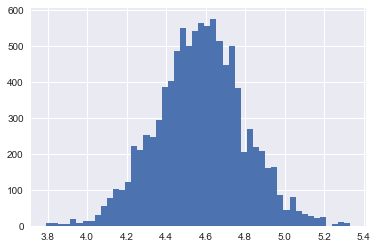

In [42]:
plt.hist(samples[200:], bins=50);

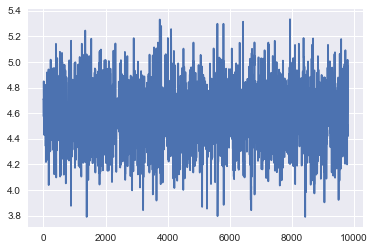

In [43]:
plt.plot(samples[200:]);

## Alternative MCMC Strategies and Use Cases

This is a _VERY_ simple implementation of the Metropolis algorithm. As you work on more and more complex models you will find the simpler algorithms run into problems. In this case, metropolis assumes symmetrical distributions. Metropolis-Hastings accounts for assymetric distributions.

* **Metropolis**- What we did! Simplest of MCMC samplers.
* **Metropolis-Hastings**- Almost as simple as our metropolis algo above but also handles assymetric distributions
* **Gibbs** - Best for models with conditional distributions, a special case of Metropolis-Hastings
* **Hamiltonian (HMC)** - Much more efficient for models with many parameters (compared to Metropolis/Gibbs)
* **NUTS (No U-Turn Sampler)**- HMC has issues with tuning the correct step size. NUTS attempts to automate and tune this choice.

### HUGE thank you to **Alex Companioni (@achompas)** for helping me summarize these!

## The Use of Tooling

Now with some tooling, let's return to our revenue optimization problem from above. Here's how we can model it in PyMC3.

In [44]:
import pymc3 as pm

with pm.Model() as m:
    a = pm.Normal('a', mu=0, sd=10)
    h = pm.Normal('h', mu=8, sd=10)
    k = pm.Normal('k', mu=24000, sd=1000)
    sigma = pm.Lognormal('sigma', mu=2, sd=5)
    
    
    y_pred = a * (x_data - h)**2 + k
    error = observed_y - y_pred
    
    pm.Normal('error', mu=0, sd=sigma, observed=error)
    
    trace = pm.sample(draws=15000, n_init=25000)

 83%|████████▎ | 12874/15500 [00:34<00:06, 383.19it/s]//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 29 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 15485/15500 [00:40<00:00, 483.92it/s]//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.918487953966, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 48 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 15500/15500 [00:40<00:00, 386.17it/s]


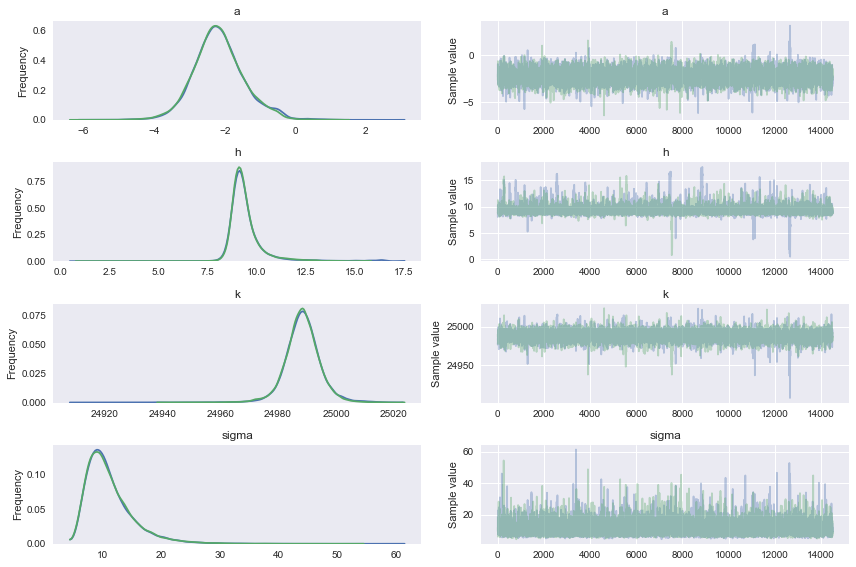

In [45]:
pm.traceplot(trace[500:]);

In [46]:
pm.summary(trace[500:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-2.183743,0.719970,0.012985,-3.467728,-0.565113,2886.0,1.000343
h,9.407637,1.017161,0.031734,8.216660,11.290476,953.0,1.000853
k,24988.107710,6.182845,0.113028,24976.687176,25000.917247,2914.0,1.000007
sigma,11.345957,4.173282,0.064911,5.349892,19.271929,3686.0,0.999972


# Visualizing the Possibilities

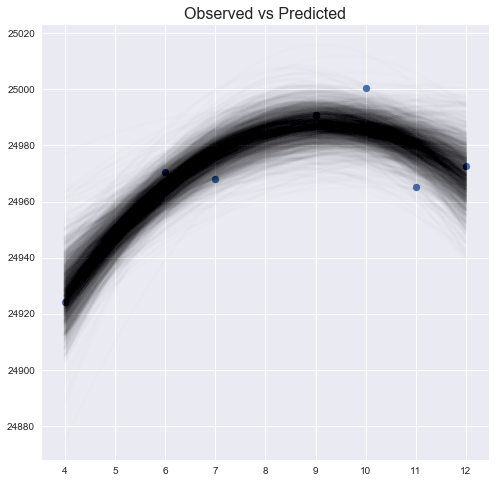

In [47]:
plt.figure(figsize=(8,8))
plt.title('Observed vs Predicted', size=16)

sampled_a = trace[14000:]['a']
sampled_h = trace[14000:]['h']
sampled_k = trace[14000:]['k']

x_eval = np.linspace(4, 12, num=50)

for a_sample, h_sample, k_sample in zip(sampled_a, sampled_h, sampled_k):
    y_eval = a_sample * (x_eval - h_sample)**2 + k_sample
    plt.plot(x_eval, y_eval, alpha=0.0065, c='k', linewidth=3.0);
    
plt.scatter(x_data, observed_y);

We get pretty close to what we know the optimal setting to be! It should be 9.25 and this gives us 9.75. We also get a concept of uncertainty.

# When Things Go Wrong

Imagine you have a logistic regression model that you can use to better predict which delivery drivers will be best to deliver a product to your customer. You create the model but don't know the threshold you should set for the probabilities even through cross-validation because human behavior is complex.

Instead we design an experiment:

Try many thresholds randomly and infer the optimum using a mathematical model.

## First step

Think through the effect of the model. When the value was closer to one, the possible drivers would be the same as production. In other words a sort of control. As the threshold was lowered though, drivers would be filtered out... but lower it too much and _all_ drivers would be filtered out and delivery performance would degrade.

We can develop a simple mathematical model to encapsulate this:

$$ Y = a * \frac{(x - h)^2}{x - k} + C\ $$

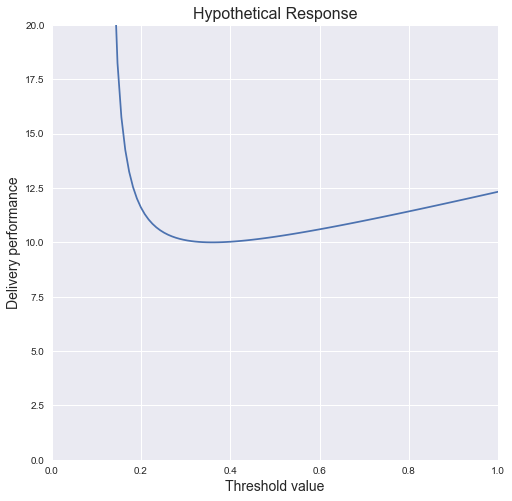

In [48]:
X = np.linspace(0.13, 1, num=101)
Y = 5*((X - 0.36)**2) / (X - 0.12) + 10

plt.figure(figsize=(8,8))
plt.title('Hypothetical Response', size=16)
plt.ylim(0, 20)
plt.xlim(0,1)
plt.xlabel('Threshold value', size=14)
plt.ylabel('Delivery performance', size=14)
plt.plot(X, Y);

In [49]:
X_ = np.linspace(0.13, 1, num=30)
Y_ = 3*((X_ - 0.36)**2) / (X_ - 0.12) + 10 + np.random.normal(loc=0, scale=2, size=len(X_))

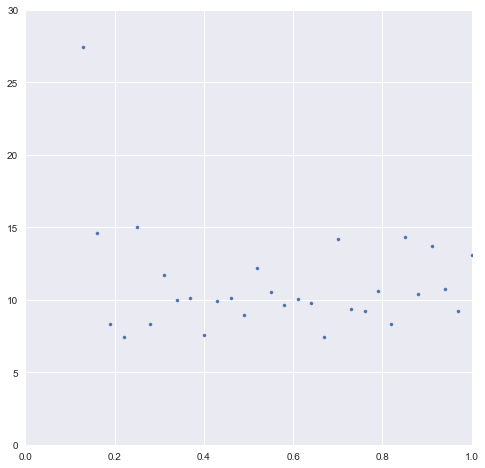

In [50]:
plt.figure(figsize=(8,8))
plt.xlim(0,1)
plt.ylim(0,30)
plt.scatter(X_, Y_, s=10.0);

In [51]:
import pymc3 as pm

with pm.Model() as m:
    a = pm.Uniform('a', lower=0.0, upper=20.0)
    h = pm.Uniform('h', lower=0.0, upper=1.0)# pm.Normal('h', mu=0.36, sd=0.05)
    k = pm.Uniform('k', lower=0.0, upper=1.0)#pm.Normal('k', mu=0.5, sd=0.05)
    C = pm.Uniform('C', lower=1.0, upper=30.) #pm.Normal('C', mu=8, sd=1)
    sigma = pm.Lognormal('sigma', mu=2, sd=2)
    
    
    y_pred = a * ((X_ - h)**2)/(X_ - k) + C
    error = Y_ - y_pred
    
    pm.Normal('error', mu=0, sd=sigma, observed=error)
    
    trace = pm.sample(draws=15000, tune=1000)

 80%|███████▉  | 12744/16000 [01:41<00:26, 124.36it/s]//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 816 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 15995/16000 [02:03<00:00, 117.14it/s]//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.685322981844, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 1808 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 16000/16000 [02:03<00:00, 129.39it/s]


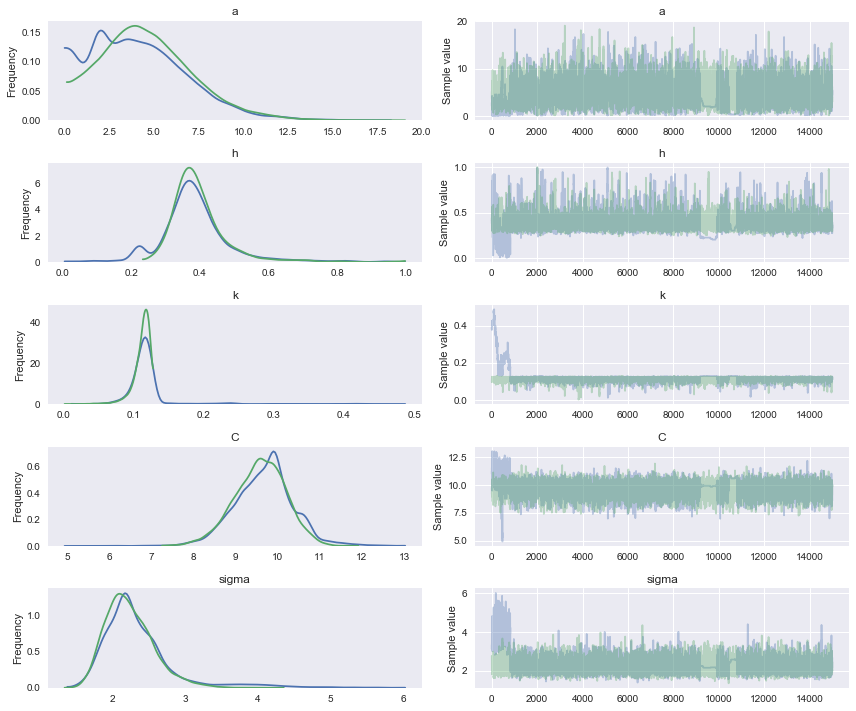

In [52]:
pm.traceplot(trace);

In [53]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,4.416728,2.639221,0.090846,0.048761,9.204302,316.0,1.006870
h,0.392786,0.101406,0.004056,0.204221,0.600584,144.0,1.005379
k,0.116121,0.031133,0.002632,0.077128,0.129429,7.0,1.022851
C,9.629068,0.663142,0.022383,8.290903,10.825430,66.0,1.005250
sigma,2.294955,0.440636,0.028088,1.616050,3.083408,12.0,1.015125


# But When They Work!!

In [54]:
X_ = np.linspace(0.13, 1, num=30)
Y_ = 3*((X_ - 0.36)**2) / (X_ - 0.12) + 10 + np.random.normal(loc=0, scale=2, size=len(X_))

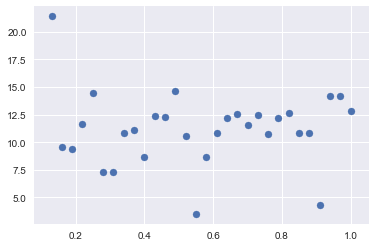

In [55]:
plt.scatter(X_, Y_);

In [56]:
import numpy as np
import pymc3 as pm 

with pm.Model() as m:
    a = pm.Uniform('a', lower=0.0, upper=10.0)
    h = pm.Normal('h', mu=0.5, sd=0.05)
    k = pm.Normal('k', mu=0.2, sd=0.05)
    C = pm.Normal('C', mu=8, sd=1)
    sigma = pm.Uniform('sigma', lower=1, upper=30)
    
    
    y_pred = a * ((X_ - h)**2)/(X_ - k) + C
    error = Y_ - y_pred
    
    pm.Normal('error', mu=0, sd=sigma, observed=error)
    
    trace = pm.sample(draws=15000, tune=1500)

 95%|█████████▍| 15639/16500 [01:13<00:03, 220.15it/s]//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 1844 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 16499/16500 [01:17<00:00, 242.86it/s]//anaconda/lib/python3.4/site-packages/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 1548 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 16500/16500 [01:17<00:00, 213.07it/s]


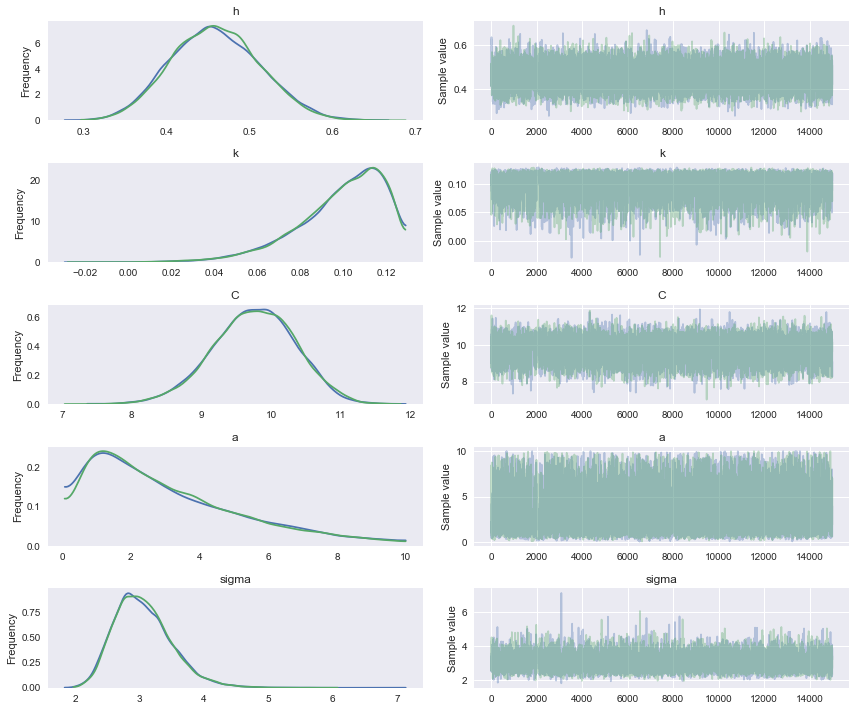

In [57]:
pm.traceplot(trace);

In [58]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
h,0.458770,0.053379,0.000652,0.353310,0.559564,7557.0,0.999971
k,0.098601,0.020222,0.000302,0.059458,0.128916,3815.0,0.999980
C,9.749317,0.590578,0.007139,8.547323,10.854736,6397.0,0.999967
a,3.088058,2.198490,0.032807,0.107337,7.567388,4226.0,0.999967
sigma,3.058598,0.445687,0.005274,2.269013,3.945667,7019.0,0.999983


### Special big thanks to **Austin Rochford @AustinRochford**!

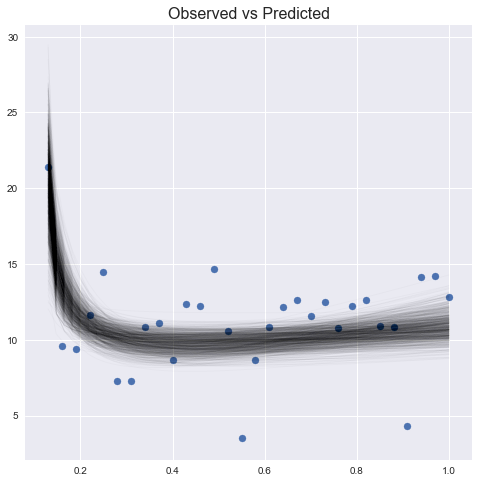

In [59]:
plt.figure(figsize=(8,8))
plt.title('Observed vs Predicted', size=16)

sampled_a = trace[14000:]['a']
sampled_h = trace[14000:]['h']
sampled_k = trace[14000:]['k']
sampled_C = trace[14000:]['C']

x_eval = np.linspace(0.13, 1.0, num=50)

for a_sample, h_sample, k_sample, C_sample in list(zip(sampled_a, sampled_h, sampled_k, sampled_C))[:1000]:
    y_eval = a_sample * ((x_eval - h_sample)**2)/(x_eval - k_sample) + C_sample
    plt.plot(x_eval, y_eval, alpha=0.02, c='k', linewidth=1.0);
    
plt.scatter(X_, Y_);